## Medical Diagnosis With the Use of X-Ray

## Import Package

In [1]:
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle

sns.set()

In [3]:
# Set size
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

## Datasets

<p>Datasets from https://arxiv.org/abs/1705.02315 are used and explored in this section</p>

In [4]:
train_data = pd.read_csv("train-small.csv")
valid_data = pd.read_csv("valid-small.csv")
test_data = pd.read_csv("test.csv")

In [5]:
print(f"Train data: {train_data.shape[0]} rows, {train_data.shape[1]} columns")
print(f"Valid data: {valid_data.shape[0]} rows")
print(f"Test data: {test_data.shape[0]} rows")

Train data: 1000 rows, 16 columns
Valid data: 200 rows
Test data: 420 rows


In [6]:
print(f"Train: Total IDs = {train_data['PatientId'].count()}, Unique IDs = {train_data['PatientId'].nunique()}")
print(f"Validation: Total IDs = {valid_data['PatientId'].count()}")
print(f"Test: Total IDs = {test_data['PatientId'].count()}")

Train: Total IDs = 1000, Unique IDs = 928
Validation: Total IDs = 200
Test: Total IDs = 420


### Data Leakage

<p> Making sure there is no data leakage in the train, validation, and test datasets</p>

In [7]:
def detect_data_leakage(data1, data2, id_column):
    ids_1 = set(data1[id_column])
    ids_2 = set(data2[id_column])
    overlap = ids_1 & ids_2
    return len(overlap) > 0

In [8]:
print(f"Leakage train-test: {detect_data_leakage(train_data, test_data, 'PatientId')}")
print(f"Leakage valid-test: {detect_data_leakage(valid_data, test_data, 'PatientId')}")

Leakage train-test: False
Leakage valid-test: False


### Data Lables

In [9]:
# Show all the labels
label_columns = [col for col in train_data.columns if col not in ['Image', 'PatientId']]
print(f"Total labels: {len(label_columns)} -> {label_columns}")

# Breakdown by classes
for label in label_columns:
    print(f"{label}: {train_data[label].sum()} samples")

Total labels: 14 -> ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Atelectasis: 106 samples
Cardiomegaly: 20 samples
Consolidation: 33 samples
Edema: 16 samples
Effusion: 128 samples
Emphysema: 13 samples
Fibrosis: 14 samples
Hernia: 2 samples
Infiltration: 175 samples
Mass: 45 samples
Nodule: 54 samples
Pleural_Thickening: 21 samples
Pneumonia: 10 samples
Pneumothorax: 38 samples


### Data Visualization

Displaying images


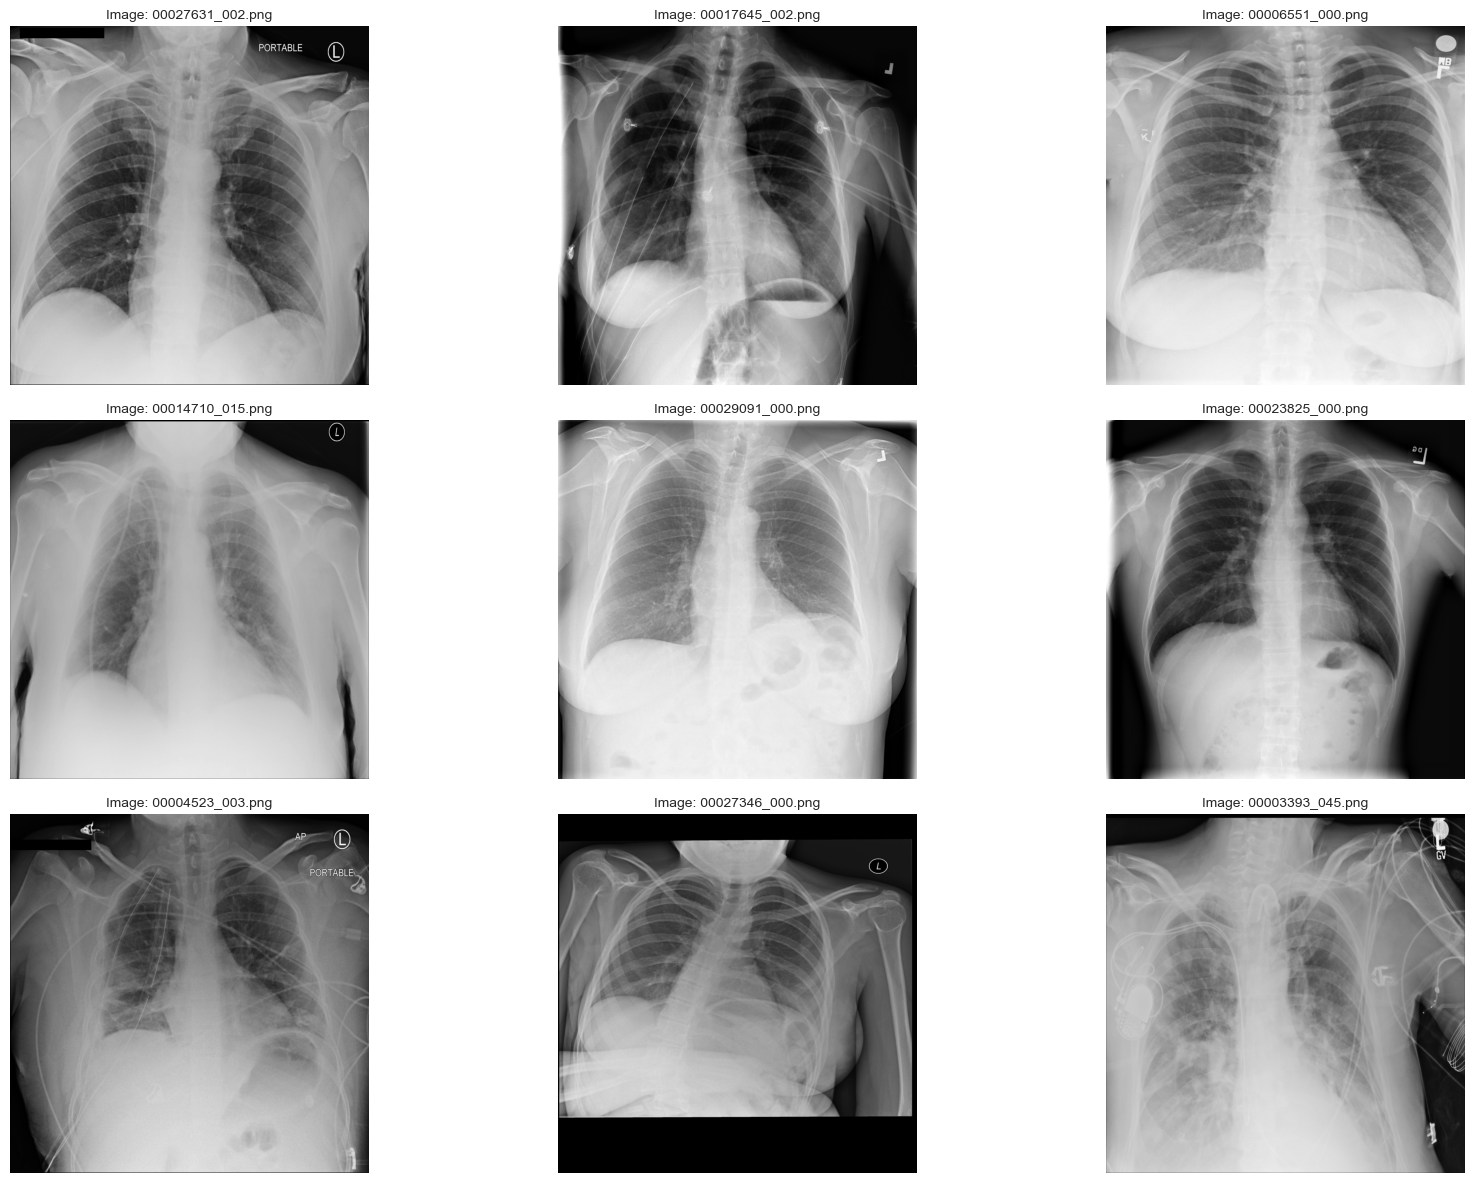

In [10]:
image_filenames = train_data['Image'].values
random_images = np.random.choice(image_filenames, 9, replace=False)

image_dir = 'images-small'  # Sesuaikan direktori gambar
print("Displaying images")

plt.figure(figsize=(18, 12))

for idx, img_name in enumerate(random_images, 1):
    # Pastikan path tidak memiliki karakter tambahan
    img_path = os.path.join(image_dir, img_name.strip())  # Menghapus spasi atau tanda kutip
    try:
        img_data = plt.imread(img_path)  # Membaca gambar
        plt.subplot(3, 3, idx)
        plt.imshow(img_data, cmap='gray')
        plt.axis('off')
        plt.title(f"Image: {img_name}", fontsize=10)
    except OSError as e:
        print(f"Error reading image {img_path}: {e}")  # Tampilkan error jika gagal membaca gambar

plt.tight_layout()
plt.show()

#### Single Image Analysis from Datasets

Dimesnion: 1024 x 1024 pxel, with 1 colour
Max pixel: 1.0000, minimum: 0.0000
Avg piksel: 0.4669, standar deviation: 0.2492


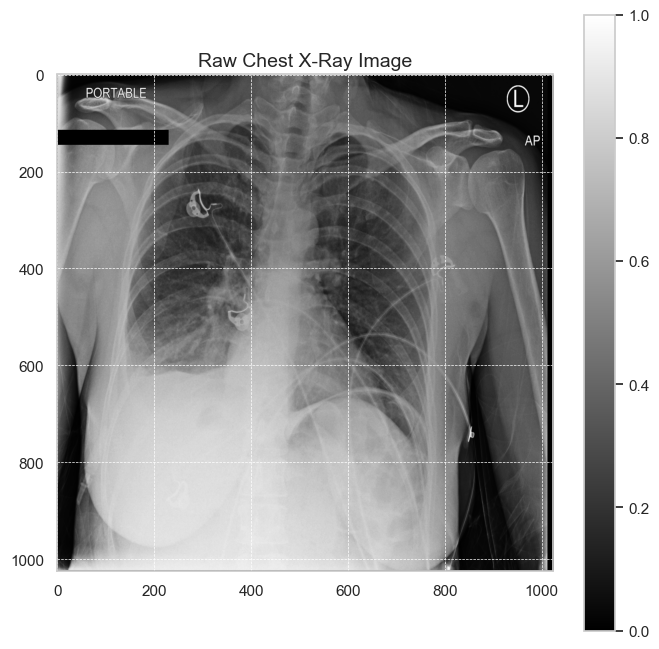

In [11]:
# Showing the first image from the data
first_image = train_data.loc[1, 'Image']
image_path = os.path.join(image_dir, first_image)
image_data = plt.imread(image_path)

# Show the pixels
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray')
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.colorbar()
plt.title('Raw Chest X-Ray Image', fontsize=14)
print(f"Dimesnion: {image_data.shape[0]} x {image_data.shape[1]} pxel, with 1 colour")
print(f"Max pixel: {image_data.max():.4f}, minimum: {image_data.min():.4f}")
print(f"Avg piksel: {image_data.mean():.4f}, standar deviation: {image_data.std():.4f}")

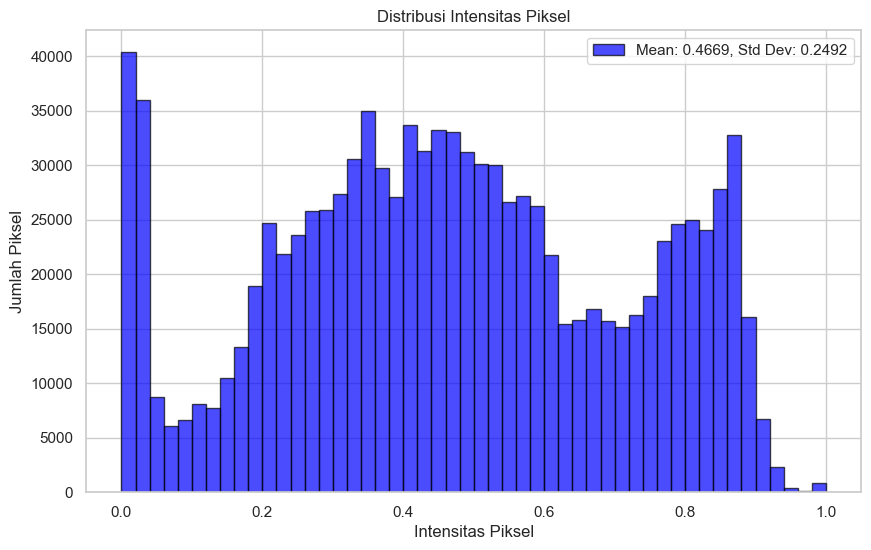

In [12]:
# Pixel Distribution Intensity
pixels_flat = image_data.flatten()
plt.figure(figsize=(10, 6))
plt.hist(pixels_flat, bins=50, color='blue', alpha=0.7, edgecolor='black', 
         label=f'Mean: {pixels_flat.mean():.4f}, Std Dev: {pixels_flat.std():.4f}')
plt.legend(loc='upper right')
plt.title('Distribusi Intensitas Piksel', fontsize=12)
plt.xlabel('Intensitas Piksel')
plt.ylabel('Jumlah Piksel')
plt.show()

### Preparing Image using Keras

<p>Using keras for pre processing. The pre processing generator will substitute each pixel value in the image with a new value determined by: </p>
$$\frac{x_i - \mu}{\sigma}$$
$\mu$= mean and $\sigma$ = standard deviation

In [13]:
# Creating Genrator with Keras
from keras.preprocessing.image import ImageDataGenerator

def create_train_generator(data, image_directory, x_column, y_columns, shuffle=True, 
                           batch_size=8, random_seed=42, img_width=320, img_height=320):
    """
    Generator for training with normalization
    """
    print("generator for training...")
    
    generator_config = ImageDataGenerator(
        samplewise_center=True,                # per sample
        samplewise_std_normalization=True)     # per sample
    
    train_generator = generator_config.flow_from_dataframe(
        dataframe=data,
        directory=image_directory,
        x_col=x_column,
        y_col=y_columns,
        class_mode="raw",                      # Mode target: raw values
        batch_size=batch_size,
        shuffle=shuffle,
        seed=random_seed,
        target_size=(img_width, img_height))
    
    return train_generator


# Creating test and validation generator
def create_validation_test_generators(validation_data, test_data, training_data, 
                                      image_directory, x_column, y_columns, 
                                      normalization_sample=100, batch_size=8, 
                                      random_seed=42, img_width=320, img_height=320):
    """
    Generator for validation and test, with normalization in regards of the training.
    """
    print(f"\nExtract {normalization_sample} picture from training for normalization...")

    raw_train_gen = ImageDataGenerator().flow_from_dataframe(
        dataframe=training_data, 
        directory=image_directory, 
        x_col=x_column, 
        y_col=y_columns, 
        class_mode="raw", 
        batch_size=normalization_sample, 
        shuffle=True, 
        target_size=(img_width, img_height))
    
    # somple for mean and std
    train_sample = raw_train_gen.next()[0]

    # Creating generator with mean and std from traing data
    normalization_config = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True)
    normalization_config.fit(train_sample)

    print("\nGenerator for val...")
    validation_generator = normalization_config.flow_from_dataframe(
        dataframe=validation_data,
        directory=image_directory,
        x_col=x_column,
        y_col=y_columns,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=random_seed,
        target_size=(img_width, img_height))
    
    print("\nGenerator for test...")
    test_generator = normalization_config.flow_from_dataframe(
        dataframe=test_data,
        directory=image_directory,
        x_col=x_column,
        y_col=y_columns,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=random_seed,
        target_size=(img_width, img_height))
    
    return validation_generator, test_generator

In [14]:
# Initialize and create data generators
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
          'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

train_generator = create_train_generator(train_data, image_dir, "Image", labels)
valid_generator, test_generator = create_validation_test_generators(valid_data, test_data, train_data, image_dir, "Image", labels)

generator for training...
Found 1000 validated image filenames.

Extract 100 picture from training for normalization...
Found 1000 validated image filenames.

Generator for val...
Found 200 validated image filenames.

Generator for test...
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8387593..1.8070958].


Image dimensions: 320 x 320 pixels
Max pixel value: 2.4677, Min pixel value: -3.0773
Mean pixel value: 0.0000, Std dev: 1.0000


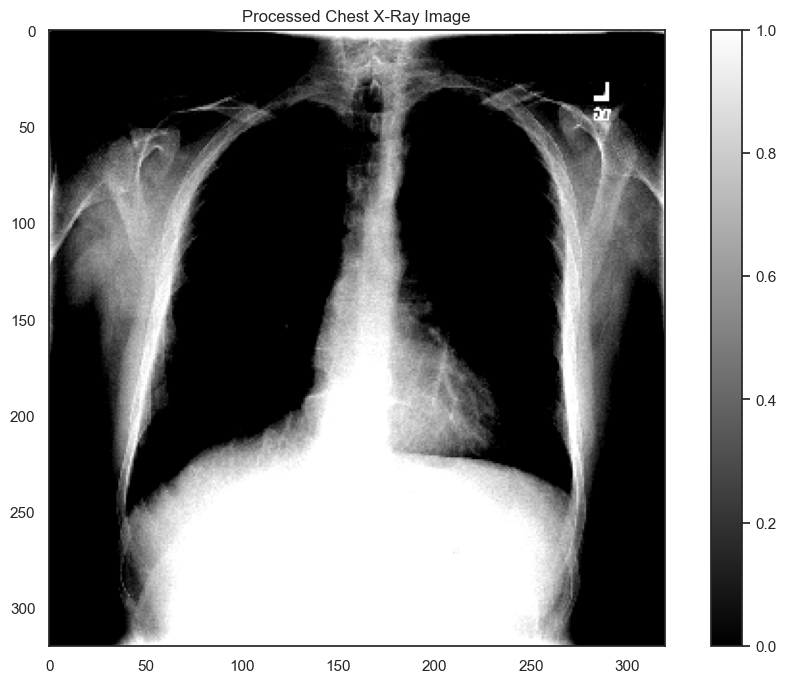

In [15]:
# Display a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Processed Chest X-Ray Image')
print(f"Image dimensions: {generated_image.shape[1]} x {generated_image.shape[2]} pixels")
print(f"Max pixel value: {generated_image.max():.4f}, Min pixel value: {generated_image.min():.4f}")
print(f"Mean pixel value: {generated_image.mean():.4f}, Std dev: {generated_image.std():.4f}")

In [16]:
print(generated_image.shape, generated_image[0].shape)
print(image_data.shape)

(8, 320, 320, 3) (320, 320, 3)
(1024, 1024)


C:\Users\Shyl\AppData\Local\Temp\ipykernel_21336\73170089.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(image_data.ravel(),
C:\Users\Shyl\AppData\Local\Temp\ipykernel_21336\73170089.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image[0].ravel(),


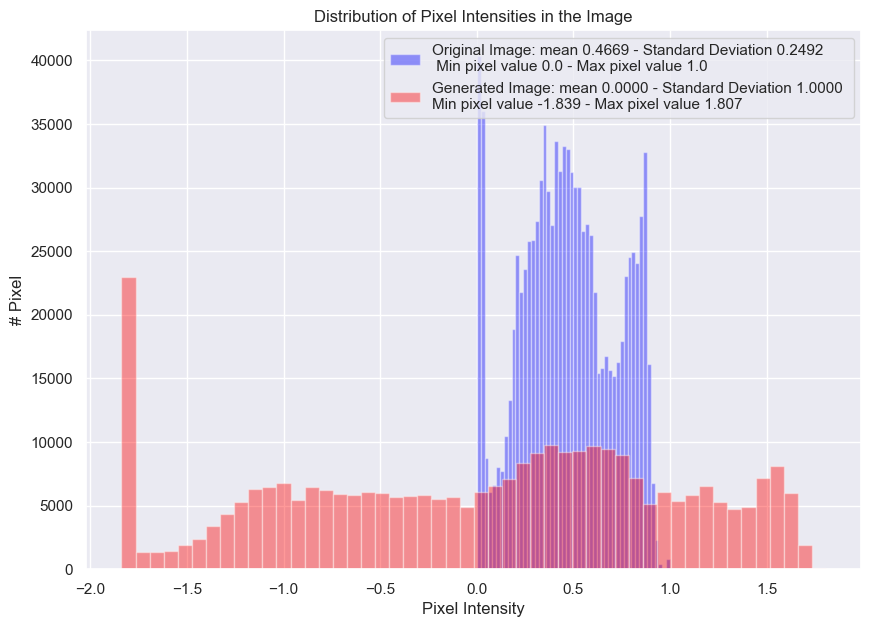

In [17]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(image_data.ravel(), 
             label=f'Original Image: mean {np.mean(image_data):.4f} - Standard Deviation {np.std(image_data):.4f} \n '
             f'Min pixel value {np.min(image_data):.4} - Max pixel value {np.max(image_data):.4}',
             color='blue', 
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}', 
             color='red', 
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()

#### Class Imbalance

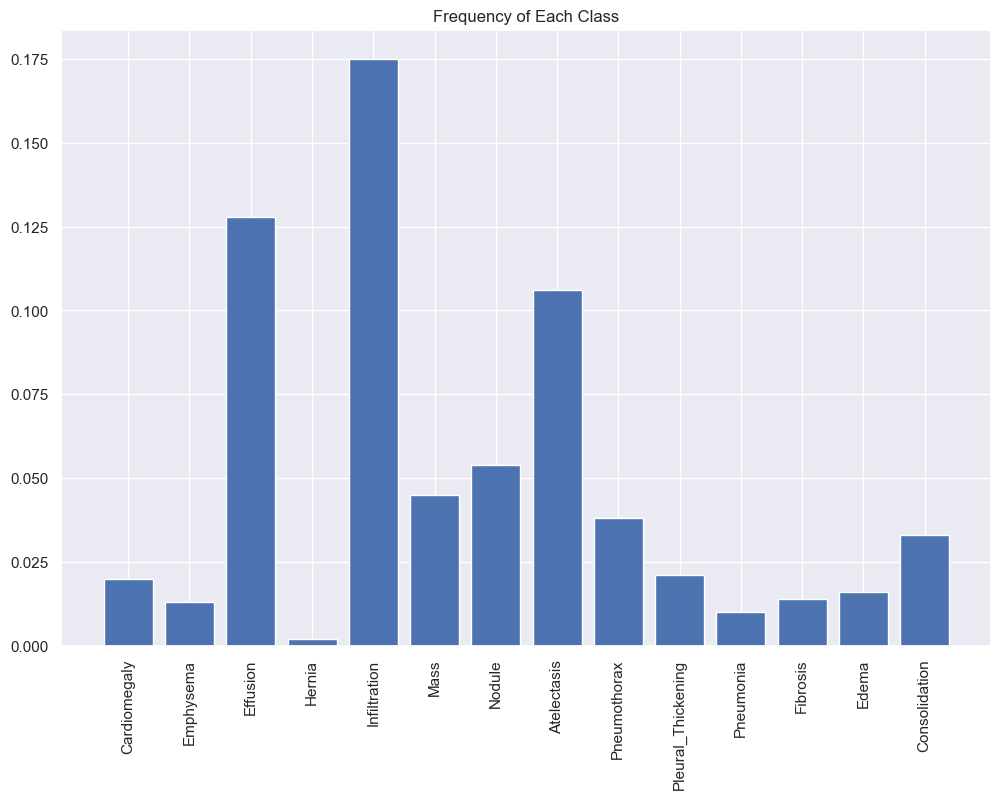

In [18]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

<p>This plot reveals that the prevalence of positive cases varies significantly across different pathologies, with trends that align closely with those observed in the full dataset. From here, the class imbalance between pathologies is visible, with Hernia has the greatest imbalance, as well as Infiltration has the least imbalance across the pathologies</p>

<p>When there is class imbalance, the Cross-Entropy Loss are used. Normal Cross-Entropy for Single case for the $i$-th training case given by:
$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$
where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output. For any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss.
Using the training set $\mathcal{D}$ of size $N$, the average Cross-Entropy over all data can be expressed as:

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$
The loss will be dominated by the negative class. The negative examples will appear more frequently, especially in imbalanced datasets, which skews the overall loss towards the majority class. The contribution of each class:  

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$</p>

In [19]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N  # broadcasting of N to a line vector of dim num_classes

    return positive_frequencies, negative_frequencies

In [20]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

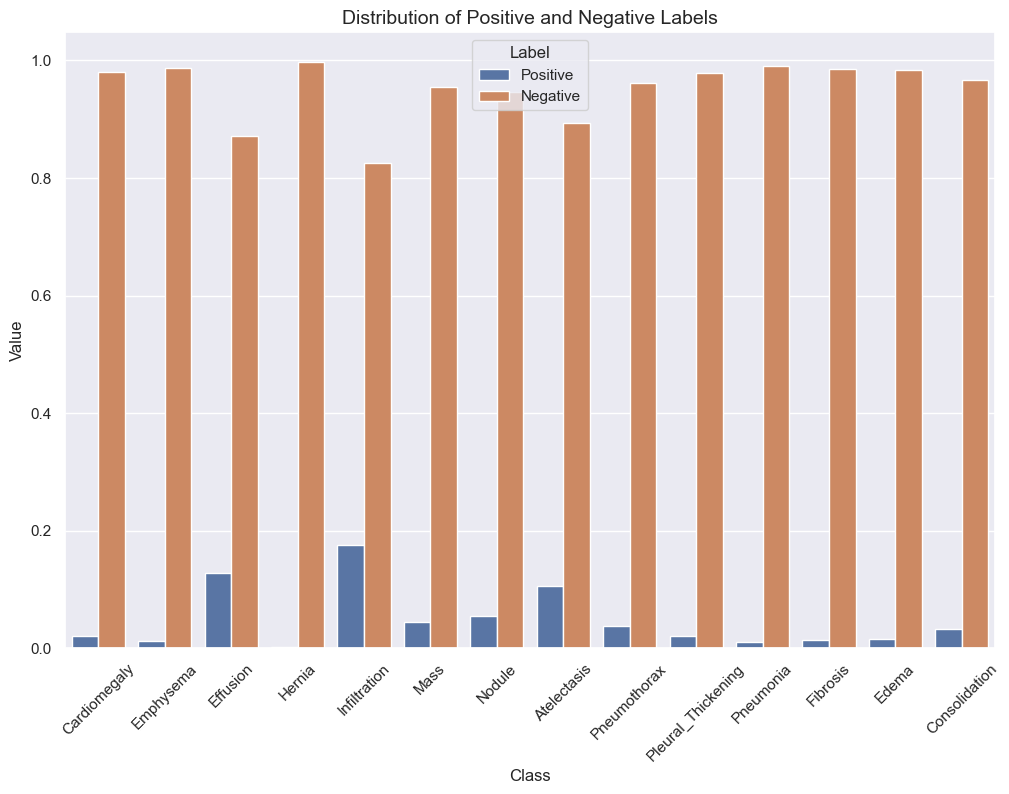

In [21]:
# Misalnya labels, freq_pos, dan freq_neg sudah didefinisikan
data_pos = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data_neg = pd.DataFrame({"Class": labels, "Label": "Negative", "Value": freq_neg})

# Gabungkan keduanya dengan pd.concat
data = pd.concat([data_pos, data_neg], ignore_index=True)

# Plot
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.title('Distribution of Positive and Negative Labels', fontsize=14)
plt.xticks(rotation=45)
plt.show()

<p> The contribution should be equal:

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

The contribution of positive and negative labels will be balanced.</p>

In [22]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

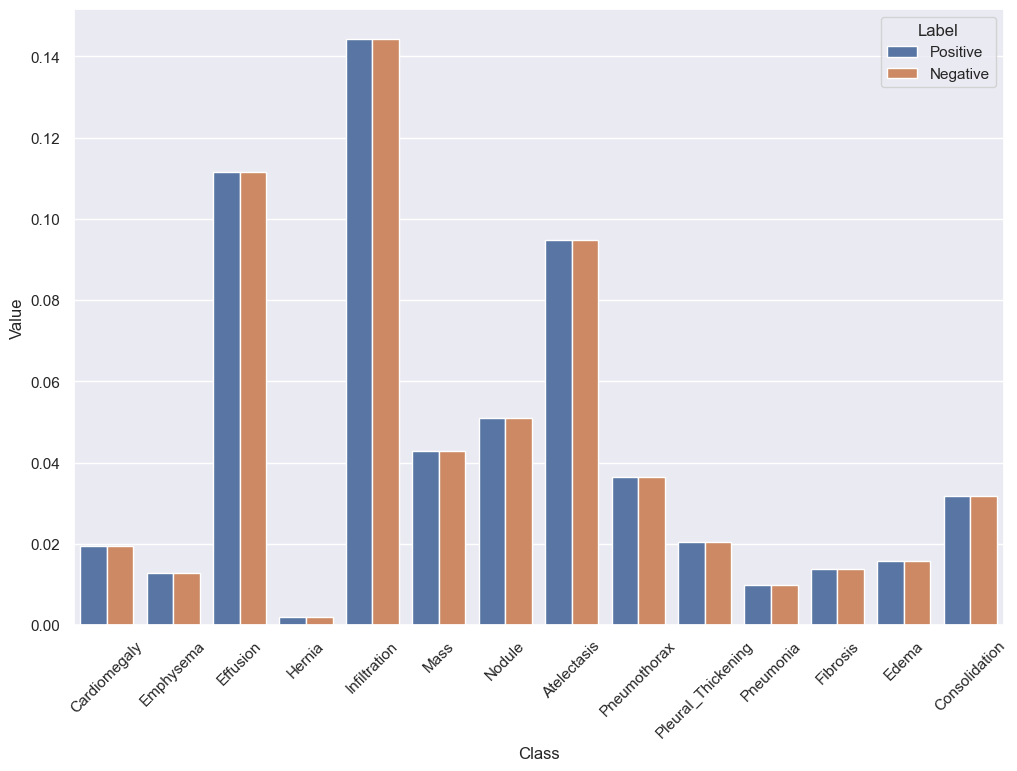

In [23]:
# Misalkan labels, pos_contribution, dan neg_contribution sudah didefinisikan
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})

# Gunakan pd.DataFrame dan pd.concat untuk menggantikan append
negative_data = pd.DataFrame(
    [{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(neg_contribution)]
)

# Gabungkan kedua DataFrame
data = pd.concat([data, negative_data], ignore_index=True)

# Plot grafik
plt.xticks(rotation=45)
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

<p>As shown, applying these weightings equalizes the contribution of positive and negative labels to the loss function. Once the weights have been calculated, the weighted loss functioned expressed as:
$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$</p>

### Weighted Loss

In [24]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon))
        return loss
    
    return weighted_loss             # this is a function taking 2 arguments y_true and y_pred

### DenseNet121

<p>Densenet is used, where each layer is connected to all other layers.</p>

In [25]:
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing import image

def load_C3M3_model():
   
    class_pos = train_data.loc[:, labels].sum(axis=0)
    class_neg = len(train_data) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    print("Got loss weights")
    # create the base pre-trained model
    base_model = DenseNet121(weights="C:/Users/Shyl/Downloads/densenet.hdf5", include_top=False)
    print("Loaded DenseNet")
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    model.load_weights("C:/Users/Shyl/Downloads/pretrained_model.h5")
    print("Loaded Weights")
    return model

In [26]:
model = load_C3M3_model()

Got loss weights
Loaded DenseNet
Added layers
Compiled Model
Loaded Weights


In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

In [28]:
# Print out the total number of layers
layers_num = model.layers
print('total number of layers =',len(layers_num))

total number of layers = 429


In [29]:
conv2D_layers = [layer for layer in model.layers 
                if str(type(layer)).find('Conv2D') > -1]

In [30]:
print('Input =>', model.input)
print('Feature extractor output =>', model.get_layer('conv5_block16_concat').output)
print('Output =>', model.output)

Input => KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Feature extractor output => KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 1024), dtype=tf.float32, name=None), name='conv5_block16_concat/concat:0', description="created by layer 'conv5_block16_concat'")
Output => KerasTensor(type_spec=TensorSpec(shape=(None, 14), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")


### Prediction and Evaluation

In [31]:
predicted_value = model.predict_generator(test_generator, steps = len(test_generator))
predicted_value.shape

C:\Users\Shyl\AppData\Local\Temp\ipykernel_21336\820438573.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_value = model.predict_generator(test_generator, steps = len(test_generator))


(420, 14)

<p>From the ROC(Receiver Operating Characteristic), AUC(Area Under the Curve) are observed.</p>
<p>When the curve shifted more to the left that means there is more area under the curve and indicates the model is better</p>

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_roc_curve(labels, predicted_value, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_value[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals

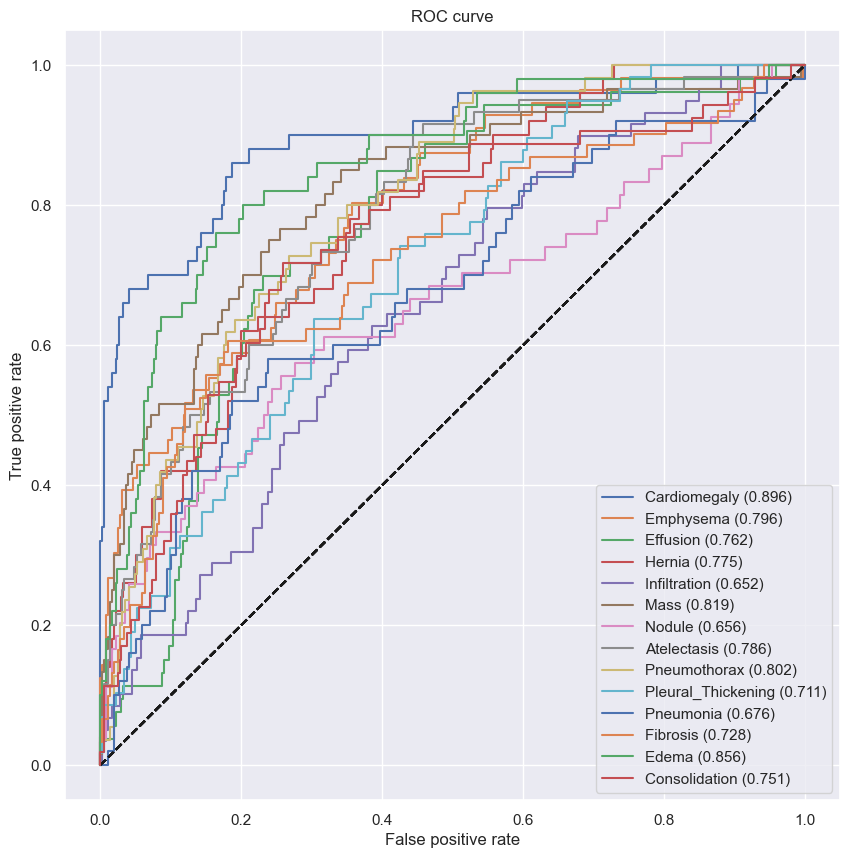

In [33]:
auc_rocs = get_roc_curve(labels, predicted_value, test_generator)

In [34]:
print("areas under the curve : {} \n for all {} classes".format(auc_rocs,len(auc_rocs)))

areas under the curve : [0.8955675675675675, 0.7963598901098901, 0.7621201994756054, 0.7750270270270271, 0.6520024414291751, 0.8193981481481482, 0.6561424812790934, 0.7856018518518518, 0.8016438356164383, 0.7105639169365594, 0.6758918918918918, 0.7283894241746198, 0.8564324324324325, 0.7514266618682844] 
 for all 14 classes


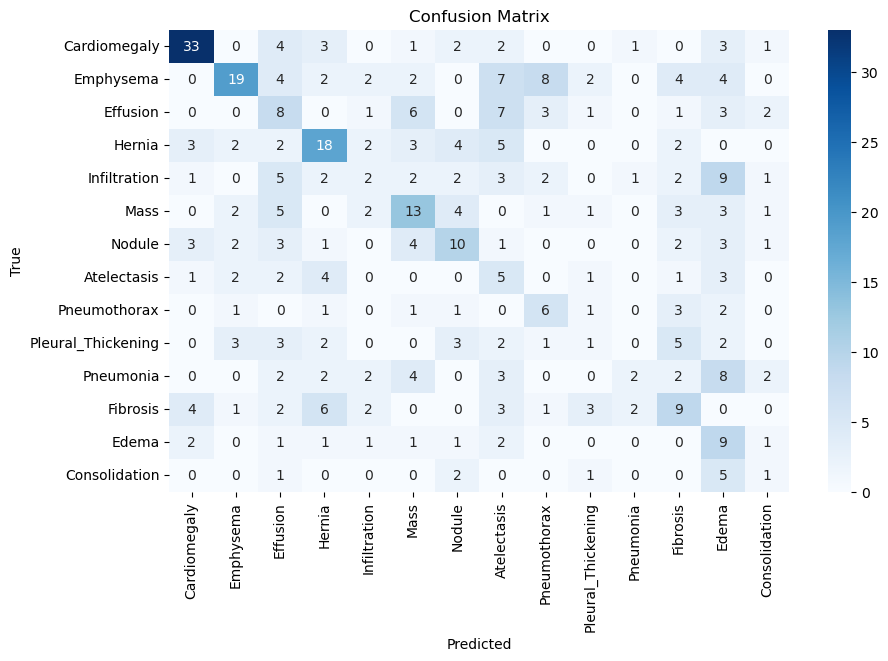

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.labels.argmax(axis=-1), predicted_value.argmax(axis=-1))
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Key Observation:
<p>1. Strong Performance: Cardiomegaly, Emphysema, and Hernia have relatively high diagonal values compared to misclassifications, indicating good performance.</p>
<p>2. Weaker Performance: Pneumonia and Pleural Thickening have lower correct predictions (4 and 5, respectively) and higher misclassification rates.</p>
<p> 3. There is noticeable confusion between certain pairs of classes that might have overlapping features:
Mass and Nodule, Fibrosis and Pneumonia
</p>